### Main Updates
* Dataset now includes average passenger count and trip duration
* Final version of fare hike correction
* For routes with no ride, replace non-count quantities by average 

### load packages

In [1]:
# for automatic reloading of modules (quick debugging)
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('..') # add parent directory to path

import numpy as np 
import pandas as pd
from utils import processing as pr
import matplotlib.pyplot as plt
import geopandas as gpd

### load data for range of time of choice
Two years and three months of data.

In [2]:
# preprocess months and years to an (N,2)-array
months = np.arange(1,3+1,1)
years = np.arange(2023,2023+1,1)
month_year = np.meshgrid(years, months)
month_year = np.array(month_year).T.reshape(-1,2)

In [3]:
month_year

array([[2023,    1],
       [2023,    2],
       [2023,    3]])

### Load Inland Manhattan Taxi Zone Data

In [4]:
zdf = pd.read_csv('../assets/taxi_zone_lookup.csv')
zdf = zdf[(zdf['Borough'] == 'Manhattan') & (~zdf['LocationID'].isin([103, 104, 105, 153, 194, 202]))]
taxi_zones = list(zdf['LocationID'].values)

In [5]:
# generate data
ts = pr.generate_processed_data(month_year, vehicle_type='yellow', by_value=['PULocationID'], additional_features=True, taxi_zones=taxi_zones)
ts.head()

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:19<00:00,  6.34s/it]


,PULocationID,pickup_datetime,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
0,4,2023-01-01 00:00:00-05:00,12,25.775000,3.716666,17.058332,2.837500,1.583333,14.916667
1,12,2023-01-01 00:00:00-05:00,1,20.520000,3.420000,12.100000,1.900000,1.000000,10.550000
2,13,2023-01-01 00:00:00-05:00,13,25.891539,3.460769,17.430769,3.242307,1.384615,12.601282
3,24,2023-01-01 00:00:00-05:00,15,21.676001,2.880666,14.941999,2.704000,1.333333,11.192222
4,41,2023-01-01 00:00:00-05:00,16,16.241875,2.216875,10.743750,1.514375,1.375000,9.560416


In [6]:
ts.pickup_datetime.min(), ts.pickup_datetime.max()

(Timestamp('2023-01-01 00:00:00-0500', tz='America/New_York'),
 Timestamp('2023-03-31 23:00:00-0400', tz='America/New_York'))

In [7]:
# basic checks, notice our code accounts for Daylight Savings Time
print('Min Date: ', ts.pickup_datetime.min())
print('Max Date: ', ts.pickup_datetime.max())
print('Taxi Zones: ' + str(ts.PULocationID.unique().min()) + ' to ' + str(ts.PULocationID.unique().max()) )
print('Memory Usage (MB): ', ts.memory_usage().sum() / 1024**2)

Min Date:  2023-01-01 00:00:00-05:00
Max Date:  2023-03-31 23:00:00-04:00
Taxi Zones: 4 to 263
Memory Usage (MB):  5.188762664794922


### postprocessing
* Adjust quantities affected by rate hike
* Account for routes with no counts in a given hour

In [9]:
ts_p = pr.postprocess_data(ts, by_value=['PULocationID'])

### Save Taxi Dataframe and Geopandas Dataframe

In [10]:
os.system('mkdir -p ../../processed_taxi_data')

# save processed taxi dataframe
ts_p.to_pickle('../../processed_taxi_data/adjusted_yellow_2023-01_2023-03_bypulocation.pkl')

In [11]:
# Geopandas dataframe
gdf = gpd.read_file('../assets/tableau/taxi_zones/taxi_zones.shp')  # read shapefile
gdf = gdf[(gdf['borough'] == 'Manhattan') & (~gdf['LocationID'].isin([103, 104, 105, 153, 194, 202]))]

# extract coordinates of zones: https://gis.stackexchange.com/questions/412817/how-to-get-lat-and-lon-from-a-geopandas-geodataframe-polygon
gdf = gdf.to_crs(4326) # reproject data
gdf['lon'] = gdf.centroid.x  
gdf['lat'] = gdf.centroid.y
gdf.reset_index(drop=True, inplace=True)

# save geopandas dataframe
gdf.to_pickle('../../processed_taxi_data/manhattan_taxi_zones.pkl')

/tmp/ipykernel_898/3470049900.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/tmp/ipykernel_898/3470049900.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


<Axes: title={'center': 'Taxi Pickups in Zone 79'}, xlabel='pickup_datetime'>

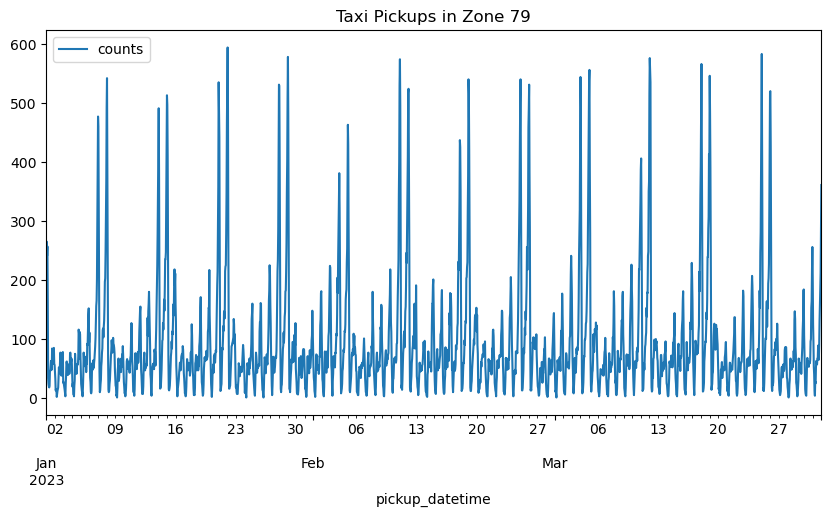

In [13]:
ts_p[ts_p['PULocationID'] == 79].plot(x='pickup_datetime', y='counts', title='Taxi Pickups in Zone 79', figsize=(10,5))